In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
%matplotlib inline

In [5]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10
NUM_PARALLEL_CALLS      = 4
TRAINING_BATCH_SIZE      = 32
SHUFFLE_BUFFER  = 5000
EPOCHS = 300

In [6]:
def pre_processing_train(example):
    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [7]:
# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [8]:
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

In [9]:
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [10]:
# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=NUM_PARALLEL_CALLS)
dataset_train = dataset_train.shuffle(buffer_size=SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=NUM_PARALLEL_CALLS)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
class InceptionResNet(object):
    def __init__(self, input_shape=(32,32,3), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes

    
    @staticmethod
    def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
        """Utility function to apply conv + BN.
        # Arguments
            x: input tensor.
            filters: filters in `Conv2D`.
            kernel_size: kernel size as in `Conv2D`.
            strides: strides in `Conv2D`.
            padding: padding mode in `Conv2D`.
            activation: activation in `Conv2D`.
            use_bias: whether to use a bias in `Conv2D`.
            name: name of the ops; will become `name + '_ac'` for the activation
                and `name + '_bn'` for the batch norm layer.
        # Returns
            Output tensor after applying `Conv2D` and `BatchNormalization`.
        """
        bn_name = None if name is None else name + '_bn'
        x = tf.keras.layers.Conv2D(filters,
                          kernel_size,
                          strides=strides,
                          padding=padding,
                          name=name)(x)
        x = tf.keras.layers.BatchNormalization(scale=False, name=bn_name)(x)
        if activation is not None:
            ac_name = None if name is None else name + '_ac'
            x = tf.keras.layers.Activation(activation, name=ac_name)(x)
        return x

    @staticmethod
    def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
        """Adds a Inception-ResNet block.
        This function builds 3 types of Inception-ResNet blocks mentioned
        in the paper, controlled by the `block_type` argument (which is the
        block name used in the official TF-slim implementation):
            - Inception-ResNet-A: `block_type='block35'`
            - Inception-ResNet-B: `block_type='block17'`
            - Inception-ResNet-C: `block_type='block8'`
        # Arguments
            x: input tensor.
            scale: scaling factor to scale the residuals (i.e., the output of
                passing `x` through an inception module) before adding them
                to the shortcut branch.
                Let `r` be the output from the residual branch,
                the output of this block will be `x + scale * r`.
            block_type: `'block35'`, `'block17'` or `'block8'`, determines
                the network structure in the residual branch.
            block_idx: an `int` used for generating layer names.
                The Inception-ResNet blocks
                are repeated many times in this network.
                We use `block_idx` to identify
                each of the repetitions. For example,
                the first Inception-ResNet-A block
                will have `block_type='block35', block_idx=0`,
                and the layer names will have
                a common prefix `'block35_0'`.
            activation: activation function to use at the end of the block
                (see [activations](../activations.md)).
                When `activation=None`, no activation is applied
                (i.e., "linear" activation: `a(x) = x`).
        # Returns
            Output tensor for the block.
        # Raises
            ValueError: if `block_type` is not one of `'block35'`,
                `'block17'` or `'block8'`.
        """
        if block_type == 'block35':
            branch_0 = InceptionResNet.conv2d_bn(x, 32, 1)
            branch_1 = InceptionResNet.conv2d_bn(x, 32, 1)
            branch_1 = InceptionResNet.conv2d_bn(branch_1, 32, 3)
            branch_2 = InceptionResNet.conv2d_bn(x, 32, 1)
            branch_2 = InceptionResNet.conv2d_bn(branch_2, 32, 3)
            branch_2 = InceptionResNet.conv2d_bn(branch_2, 48, 3)
            branches = [branch_0, branch_1, branch_2]
        elif block_type == 'block17':
            branch_0 = InceptionResNet.conv2d_bn(x, 192, 1)
            branch_1 = InceptionResNet.conv2d_bn(x, 128, 1)
            branch_1 = InceptionResNet.conv2d_bn(branch_1, 160, [1, 7])
            branch_1 = InceptionResNet.conv2d_bn(branch_1, 192, [7, 1])
            branches = [branch_0, branch_1]
        elif block_type == 'block8':
            branch_0 = InceptionResNet.conv2d_bn(x, 192, 1)
            branch_1 = InceptionResNet.conv2d_bn(x, 192, 1)
            branch_1 = InceptionResNet.conv2d_bn(branch_1, 224, [1, 3])
            branch_1 = InceptionResNet.conv2d_bn(branch_1, 256, [3, 1])
            branches = [branch_0, branch_1]
        else:
            raise ValueError('Unknown Inception-ResNet block type. '
                             'Expects "block35", "block17" or "block8", '
                             'but got: ' + str(block_type))

        block_name = block_type + '_' + str(block_idx)
        channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else 3
        mixed = tf.keras.layers.Concatenate(
            axis=channel_axis, name=block_name + '_mixed')(branches)
        up = InceptionResNet.conv2d_bn(mixed,
                       tf.keras.backend.int_shape(x)[channel_axis],
                       1,
                       activation=None,
                       use_bias=True,
                       name=block_name + '_conv')

        x = tf.keras.layers.Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                          output_shape=tf.keras.backend.int_shape(x)[1:],
                          arguments={'scale': scale},
                          name=block_name)([x, up])
        if activation is not None:
            x = tf.keras.layers.Activation(activation, name=block_name + '_ac')(x)
        return x
    
    def get_model(self):
        img_input = tf.keras.layers.Input(shape=self.input_shape)
        # stem
        x = InceptionResNet.conv2d_bn(img_input, 32, 3)
        
        # inception block No reduction 320
        branch_0 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_1 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_1 = InceptionResNet.conv2d_bn(branch_1, 48, 5)
        branch_2 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_2 = InceptionResNet.conv2d_bn(branch_2, 32, 3)
        branch_2 = InceptionResNet.conv2d_bn(branch_2, 48, 3)
        branch_pool = tf.keras.layers.AveragePooling2D(3, strides=1, padding='same')(x)
        branch_pool = InceptionResNet.conv2d_bn(branch_pool, 48, 1)
        branches = [branch_0, branch_1, branch_2, branch_pool]
        x = tf.keras.layers.Concatenate(axis=3, name='mixed_5b')(branches)
        
         # 3x block35 (Inception-ResNet-A block): No reduction, 320 channels
        for block_idx in range(0, 2):
            x = InceptionResNet.inception_resnet_block(x,
                                       scale=0.17,
                                       block_type='block35',
                                       block_idx=block_idx)
        
        # Mixed 6a (Reduction-A block): half 1088
        branch_0 = InceptionResNet.conv2d_bn(x, 32, 3, strides=2, padding='valid')
        branch_1 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_1 = InceptionResNet.conv2d_bn(branch_1, 32, 3)
        branch_1 = InceptionResNet.conv2d_bn(branch_1, 48, 3, strides=2, padding='valid')
        branch_pool = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x)
        branches = [branch_0, branch_1, branch_pool]
        x = tf.keras.layers.Concatenate(axis=3, name='mixed_6a')(branches)
        
        
        # 3x block17 (Inception-ResNet-B block): No reduction 1088
        for block_idx in range(2, 4):
            x = InceptionResNet.inception_resnet_block(x,
                                       scale=0.1,
                                       block_type='block35',
                                       block_idx=block_idx)
            
        # Mixed 7a (Reduction-B block): half reduction x 2080
        branch_0 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_0 = InceptionResNet.conv2d_bn(branch_0, 32, 3, strides=2, padding='valid')
        branch_1 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_1 = InceptionResNet.conv2d_bn(branch_1, 48, 3, strides=2, padding='valid')
        branch_2 = InceptionResNet.conv2d_bn(x, 32, 1)
        branch_2 = InceptionResNet.conv2d_bn(branch_2, 32, 3)
        branch_2 = InceptionResNet.conv2d_bn(branch_2, 48, 3, strides=2, padding='valid')
        branch_pool = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x)
        branches = [branch_0, branch_1, branch_2, branch_pool]
        x = tf.keras.layers.Concatenate(axis=3, name='mixed_7a')(branches)
        
        # (Inception-ResNet-C block): No Reduction 2080
        for block_idx in range(4, 6):
            x = InceptionResNet.inception_resnet_block(x,
                                       scale=0.2,
                                       block_type='block35',
                                       block_idx=block_idx)
            
        x = InceptionResNet.inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block35',
                               block_idx=6)

        # Final convolution block: 512 channels
        x = InceptionResNet.conv2d_bn(x, 512, 1, name='conv_7b')
        
        # Classification block
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = tf.keras.layers.Dense(self.num_classes, activation='softmax', name='predictions')(x)
        
        return tf.keras.Model(img_input, x, name="InceptionResNet")

In [12]:
builder = InceptionResNet(input_shape=(DATA_CROP_ROWS, DATA_CROP_COLS, 3))

In [13]:
model = builder.get_model()

In [14]:
model.summary()

Model: "InceptionResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="./tb_logdir", write_graph=True, profile_batch=0)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=1, factor=0.5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="cifar_full_model_with_architecture.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [17]:
history = model.fit(x=dataset_train, epochs=EPOCHS, verbose=1, validation_data=dataset_test, callbacks=[tb_callback, lr_scheduler, checkpoint, early_stopping])

Epoch 1/300
   1563/Unknown - 75s 48ms/step - loss: 1.0860 - accuracy: 0.6133
Epoch 00001: val_loss improved from inf to 1.13299, saving model to cifar_full_model_with_architecture.h5
1563/1563 [==============================] - 81s 52ms/step - loss: 1.0860 - accuracy: 0.6133 - val_loss: 1.1330 - val_accuracy: 0.6250
Epoch 2/300
1561/1563 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.7530
Epoch 00002: val_loss improved from 1.13299 to 0.79415, saving model to cifar_full_model_with_architecture.h5
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7128 - accuracy: 0.7530 - val_loss: 0.7941 - val_accuracy: 0.7301
Epoch 3/300
1562/1563 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.7950
Epoch 00003: val_loss improved from 0.79415 to 0.61627, saving model to cifar_full_model_with_architecture.h5
1563/1563 [==============================] - 70s 45ms/step - loss: 0.5930 - accuracy: 0.7950 - val_loss: 0.6163 - val_accuracy: 

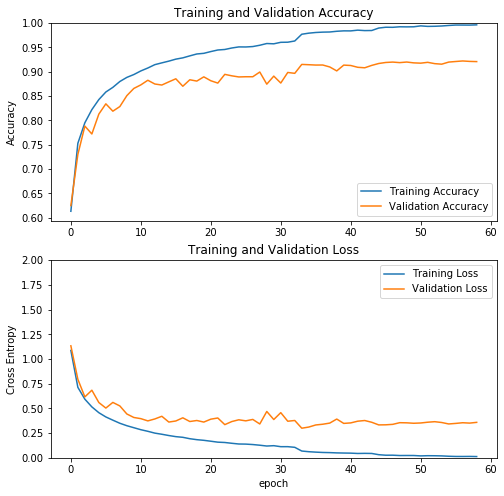

In [18]:
plot_training_curves(history)